In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
molecule = "H2"
symbols = qml.qchem.mol_data("H2")[0]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

symbols, coordinates

(['H', 'H'],
 tensor([ 0.    ,  0.    , -0.6614,  0.    ,  0.    ,  0.6614], requires_grad=True))

In [3]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.2427450126094144) [Z2]
+ (-0.2427450126094144) [Z3]
+ (-0.042072551947439224) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299361) [Z0 Z2]
+ (0.12293330449299361) [Z1 Z3]
+ (0.16768338855601356) [Z0 Z3]
+ (0.16768338855601356) [Z1 Z2]
+ (0.17059759276836803) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.044750084063019925) [Y0 Y1 X2 X3]
+ (-0.044750084063019925) [X0 X1 Y2 Y3]
+ (0.044750084063019925) [Y0 X1 X2 Y3]
+ (0.044750084063019925) [X0 Y1 Y2 X3]


In [4]:
dev = qml.device("lightning.qubit", wires=qubits)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

In [6]:
def hartree_to_ev(hartree):
  return hartree * 27.2114

In [7]:
@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [8]:
opt = qml.AdamOptimizer(stepsize=0.05)
theta = np.array(0.0, requires_grad=True)

In [9]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha or {hartree_to_ev(energy[-1]):.8f} eV")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12524428 Ha
Step = 1,  Energy = -1.13094641 Ha
Step = 2,  Energy = -1.13448618 Ha
Step = 3,  Energy = -1.13604115 Ha
Step = 4,  Energy = -1.13600457 Ha
Step = 5,  Energy = -1.13499575 Ha
Step = 6,  Energy = -1.13372864 Ha
Step = 7,  Energy = -1.13277703 Ha
Step = 8,  Energy = -1.13241922 Ha
Step = 9,  Energy = -1.13265628 Ha
Step = 10,  Energy = -1.13332254 Ha
Step = 11,  Energy = -1.13419122 Ha
Step = 12,  Energy = -1.13504429 Ha
Step = 13,  Energy = -1.13571280 Ha
Step = 14,  Energy = -1.13609885 Ha
Step = 15,  Energy = -1.13618374 Ha
Step = 16,  Energy = -1.13602200 Ha
Step = 17,  Energy = -1.13571995 Ha
Step = 18,  Energy = -1.13540183 Ha
Step = 19,  Energy = -1.13517350 Ha
Step = 20,  Energy = -1.13509639 Ha
Step = 21,  Energy = -1.13517883 Ha
Step = 22,  Energy = -1.13538411 Ha
Step = 23,  Energy = -1.13564868 Ha
Step = 24,  Energy = -1.13590321 Ha
Step = 25,  Energy = -1.13609117 Ha
Step = 26,  Energy = -1.13618150 Ha
Step = 27,  Energy = -1.13617353 Ha
St

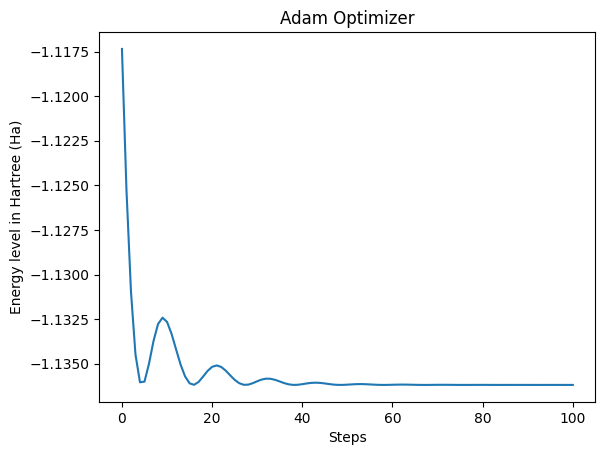

In [12]:
import matplotlib.pyplot as plt

# Create a figure object
fig = plt.figure()

# Create an axes object
ax = fig.add_subplot(1, 1, 1)

x = np.arange(0, 101)
# Plot the data on the axes object
ax.plot(x, energy)

# Set the title and labels of the graph
plt.title("Adam Optimizer")
plt.ylabel("Energy level in Hartree (Ha)")
plt.xlabel("Steps")

# Show the graph
plt.show()

In [11]:
np.save('2-Adam.npy', energy)